In [1]:
%matplotlib inline
from glob import glob
from pandas import DataFrame, read_csv, Series, to_datetime
from pickle import dump, load
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from random import randint 
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def scolor(i,n,pickColor): 
    scalar = 255 - int((i/float(n))*120) 
    if pickColor: return '#%02X%02X%02X' % (128,scalar,128)
    return '#%02X%02X%02X' % (75,scalar,200)

<h1><a id='outline'>Project Outline</a></h1>

* [Metadata](#meta)
* [Sequencing Overview](#analysis)
    *  [Contig Occupency](#occon)
*  [NMDS of annotated contigs](#nmds)
  *  [All Crops](#anmds)
  *  [Switchgrass](#sgnmds)
  *  [Miscanthus](#msnmds)
*  [MetaT Analysis](#metaT)


<h2><a id="meta">GLBRC Metadata</a></h2>

In [2]:
# import pandas as pd
metadata = DataFrame.from_csv("GLBRC_Metadata.tsv",sep='\t')
for id in metadata.index: metadata.loc[id,"type"] = metadata[metadata.index == id].plot_name[0][0:2]
metadata['Date'] = to_datetime(metadata.sampling_date)
metadata.drop(["source","sampling ID","sequencing_type","height_mean_cm","air_temp_c"],axis=1,inplace=True)
metadata=metadata.sort_values(by=["type","Date","treatment","plot_name"])
metadata.head()

,nucleic_acid_name,treatment,plot_name,rep,sampling_date,Sampling Time,type,Date
reads_file_name,,,,,,,,
11425.5.206700.GCCTTGT-AACAAGG.fastq.gz,G5R1_NF_09MAY2016_LD1,nitrogen free,G5R1_NF,1,5/9/16,12:00,G5,2016-05-09
11425.5.206700.CTGACAC-TGTGTCA.fastq.gz,G5R2_NF_09MAY2016_LD1,nitrogen free,G5R2_NF,2,5/9/16,14:43,G5,2016-05-09
11425.3.206650.CCAGTGT-AACACTG.fastq.gz,G5R3_NF_09MAY2016_LD1,nitrogen free,G5R3_NF,3,5/9/16,15:26,G5,2016-05-09
11425.5.206700.TGTACAC-GGTGTAC.fastq.gz,G5R4_NF_09MAY2016_LD1,nitrogen free,G5R4_NF,4,5/9/16,13:56,G5,2016-05-09
11425.3.206650.GAGCTCA-TTGAGCT.fastq.gz,G5R1_MAIN_09MAY2016_LD1,standard fertilization,G5R1_MAIN,1,5/9/16,12:00,G5,2016-05-09


<h2><a id="analysis">Sequencing Overview</a></h2>

In [4]:
data = read_csv("mapping/flagstats/multiqc_data/mqc_bowtie2_pe_plot_1.txt",sep="\t")
data["TotalSampleReads"] = data.sum(axis=1)
data.head()

,Sample,PE mapped uniquely,PE mapped discordantly uniquely,PE one mate mapped uniquely,PE multimapped,PE one mate multimapped,PE neither mate aligned,TotalSampleReads
0,G5R1_MAIN_01AUG2016_LD1,1897026.0,60497.0,182824.5,2918402.0,586517.5,368283.0,6013550.0
1,G5R1_MAIN_03OCT2016_LD1,3665735.0,140864.0,188402.5,3181194.0,396297.5,1251847.0,8824340.0
2,G5R1_MAIN_09MAY2016_LD1,1941784.0,63621.0,222725.0,3558865.0,668030.0,548128.0,7003153.0
3,G5R1_MAIN_12JUL2016_LD1,3068969.0,120667.0,348131.5,5028203.0,1123732.5,500007.0,10189710.0
4,G5R1_MAIN_12SEP2016_LD1,3172051.0,88905.0,221772.5,3325357.0,546661.0,804639.5,8159386.0


<h2><a id="occon">Calculate Abundance and occupancy of contigs in samples</a></h2>

In [3]:
#Individual Sample
seqPresenceCounter = {}
seqMappedCounter = {}
counter = 0
for statFName in metadata.index:
    counter += 1
    print("%i. %s" % (counter,statFName))
    for line in open("stats/filtered/%s.tsv" % statFName):
        rec = line.strip().split()
        try:
            seqMappedCounter[rec[0]] += int(rec[2])
            seqPresenceCounter[rec[0]] += int(int(rec[2])>0)
        except:
            seqMappedCounter[rec[0]] = int(rec[2])  
            seqPresenceCounter[rec[0]] = int(int(rec[2])>0)
dump(seqPresenceCounter,open("pickles/seqPresenceCounter_genes.p","wb"))
dump(seqMappedCounter,  open("pickles/seqMappedCounter_genes.p",  "wb"))  
seqPresenceDist = Series(load(open("pickles/seqPresenceCounter_genes.p","rb")))/136.0
seqPresenceDist.plot.hist();

1. 11425.5.206700.GCCTTGT-AACAAGG.fastq.gz
2. 11425.5.206700.CTGACAC-TGTGTCA.fastq.gz
3. 11425.3.206650.CCAGTGT-AACACTG.fastq.gz
4. 11425.5.206700.TGTACAC-GGTGTAC.fastq.gz
5. 11425.3.206650.GAGCTCA-TTGAGCT.fastq.gz
6. 11425.3.206650.ATAGCGG-ACCGCTA.fastq.gz
7. 11425.4.206675.CGGTTGT-AACAACC.fastq.gz
8. 11425.4.206675.TACCAAC-GGTTGGT.fastq.gz
9. 11815.1.220223.AGTCA.fastq.gz
10. 11814.1.220215.TAGCT.fastq.gz
11. 11425.3.206650.CCTCAGT-AACTGAG.fastq.gz
12. 11425.5.206700.TTCGTAC-GGTACGA.fastq.gz
13. 11425.3.206650.TGTGCGT-AACGCAC.fastq.gz
14. 11425.6.206725.ACCATCC-TGGATGG.fastq.gz
15. 11425.3.206650.GCTACGT-AACGTAG.fastq.gz
16. 11425.5.206700.CGCTTAA-GTTAAGC.fastq.gz
17. 11425.3.206650.AGAGCCT-AAGGCTC.fastq.gz
18. 11425.4.206675.TCTCTTC-GGAAGAG.fastq.gz
19. 11425.3.206650.GAGGACT-AAGTCCT.fastq.gz
20. 11425.5.206700.AGAATGC-GGCATTC.fastq.gz
21. 11425.3.206650.GTCTCCT-AAGGAGA.fastq.gz
22. 11425.5.206700.ACGATGA-GTCATCG.fastq.gz
23. 11425.3.206650.TACGCCT-AAGGCGT.fastq.gz
24. 11425.4.20667

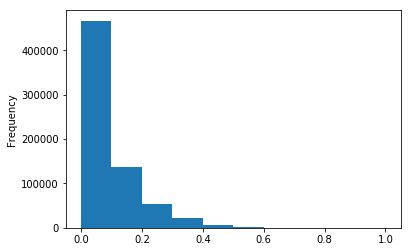

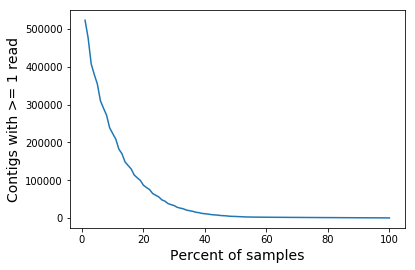

In [8]:
xs, ys = [],[]
for i in range(1,101):
    xs.append(i)
    ys.append(len(seqPresenceDist[seqPresenceDist >= i/100.0]))
plt.plot(xs,ys)
plt.xlabel('Percent of samples',fontsize=14)
plt.ylabel('Contigs with >= 1 read',fontsize=14)
plt.savefig("figures/GeneAbundance.png",bbox_inches='tight')
plt.show()

In [7]:
seqPresenceCounter = Series(load(open("pickles/seqPresenceCounter_genes.p","rb")))
seqMappedCounter = Series(load(open("pickles/seqMappedCounter_genes.p","rb")))
seqMappedCounter.describe()

count    690218.000000
mean        105.839604
std        2785.330099
min           0.000000
25%           4.000000
50%          20.000000
75%          74.000000
max      869204.000000
dtype: float64

In [6]:
seqPresenceCounter.describe()

count    690218.000000
mean         11.872868
std          14.190399
min           0.000000
25%           2.000000
50%           7.000000
75%          17.000000
max         136.000000
dtype: float64

In [11]:
seqPresenceCounter = Series(load(open("pickles/seqPresenceCounter_genes.p","rb")))
seqPresenceDist = Series(seqPresenceCounter)/136.0
print("Before Number of genes:",len(seqPresenceCounter))
keepers = set(seqPresenceCounter[seqPresenceCounter > 0].index)
print("After Number of genes:",len(keepers))
allCounts,counter = {},0
for statFName in metadata.index:
    counter += 1
    print("%i. %s" % (counter,statFName))
    sampleMeta = metadata[metadata.index == statFName]
    curSampleID = sampleMeta.nucleic_acid_name.values[0]
    allCounts[curSampleID]={}
    for line in open("stats/filtered/%s.tsv" % statFName):
        rec = line.strip().split()
        if rec[0] not in keepers:continue
        allCounts[curSampleID][rec[0]]=int(rec[2])
allCounts = DataFrame(allCounts) 
dump(allCounts,open("pickles/allCounts_genes.p","wb"))  

Before Number of genes: 690218
After Number of genes: 588412
1. 11425.5.206700.GCCTTGT-AACAAGG.fastq.gz
2. 11425.5.206700.CTGACAC-TGTGTCA.fastq.gz
3. 11425.3.206650.CCAGTGT-AACACTG.fastq.gz
4. 11425.5.206700.TGTACAC-GGTGTAC.fastq.gz
5. 11425.3.206650.GAGCTCA-TTGAGCT.fastq.gz
6. 11425.3.206650.ATAGCGG-ACCGCTA.fastq.gz
7. 11425.4.206675.CGGTTGT-AACAACC.fastq.gz
8. 11425.4.206675.TACCAAC-GGTTGGT.fastq.gz
9. 11815.1.220223.AGTCA.fastq.gz
10. 11814.1.220215.TAGCT.fastq.gz
11. 11425.3.206650.CCTCAGT-AACTGAG.fastq.gz
12. 11425.5.206700.TTCGTAC-GGTACGA.fastq.gz
13. 11425.3.206650.TGTGCGT-AACGCAC.fastq.gz
14. 11425.6.206725.ACCATCC-TGGATGG.fastq.gz
15. 11425.3.206650.GCTACGT-AACGTAG.fastq.gz
16. 11425.5.206700.CGCTTAA-GTTAAGC.fastq.gz
17. 11425.3.206650.AGAGCCT-AAGGCTC.fastq.gz
18. 11425.4.206675.TCTCTTC-GGAAGAG.fastq.gz
19. 11425.3.206650.GAGGACT-AAGTCCT.fastq.gz
20. 11425.5.206700.AGAATGC-GGCATTC.fastq.gz
21. 11425.3.206650.GTCTCCT-AAGGAGA.fastq.gz
22. 11425.5.206700.ACGATGA-GTCATCG.fastq.gz


In [3]:
allCounts = load(open("pickles/allCounts_genes.p","rb"))
allCounts["Average"] = allCounts.sum(axis=1)/float(len(allCounts.columns))
allCounts["Average"].head()

k127_10000137_15_1326      0.382353
k127_100001_75_891         0.205882
k127_10000253_2749_5290    6.426471
k127_10000269_603_1245     0.485294
k127_10000269_74_539       0.176471
Name: Average, dtype: float64

Before Filtering: 354883
After Filtering: 102292


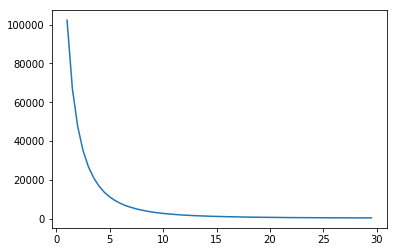

In [4]:
print("Before Filtering:",len(allCounts))
allCounts = allCounts[allCounts["Average"]>1]
xs,ys=[],[]
for i in range(1,30):
    xs.append(i)
    ys.append(len(allCounts[allCounts["Average"] > i]))
    xs.append(i+.5)
    ys.append(len(allCounts[allCounts["Average"] > i+.5]))
    
allCounts.drop("Average",axis=1,inplace=True)
print("After Filtering:",len(allCounts))
#allCounts = allCounts.transpose()
#allCounts= DataFrame(allCounts,index=allCounts.index)
dump(allCounts,open("pickles/allCountsFiltered_genes.p","wb")) 
plt.plot(xs,ys)
# plt.xlabel('Percent of samples',fontsize=14)
# plt.ylabel('Read Count',fontsize=14)
plt.savefig("figures/GeneAvgCount.png")
plt.show()

In [5]:
sortedmeta = metadata[["sampling_date","Date","type","nucleic_acid_name","treatment"]]
sortedmeta = sortedmeta.sort_values(by=["type","Date"])
counter = 0
sampleOrder = {}  
for id in sortedmeta.nucleic_acid_name:
    counter+=1
    sampleOrder[id] = counter

allCounts = DataFrame(allCounts).transpose()
allCounts['Rank'] = allCounts.index.to_series().map(sampleOrder)
allCounts.sort_values('Rank',inplace = True)
allCounts.drop('Rank', 1, inplace = True)
dump(allCounts,open("pickles/allCountsFilteredSorted_genes.p","wb"))

In [ ]:
allCounts = load(open("pickles/allCountsFilteredSorted_genes.p","rb"))

In [6]:
#allCounts = DataFrame(combined_abundance)
seed = np.random.RandomState(seed=3)
allCounts_matrix = allCounts.as_matrix()
print("Calculating Distance")
similarities = euclidean_distances(allCounts_matrix)

nsamples = len(allCounts)
print("Running NMDS with %i samples" % (nsamples))
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

Calculating Distance
Running NMDS with 136 samples


Switchgrass Unfertilized #4BCBC8
Switchgrass Fertilized #4BCBC8
Miscanthus Unfertilized #4B4BC8
Miscanthus Fertilized #4B4BC8


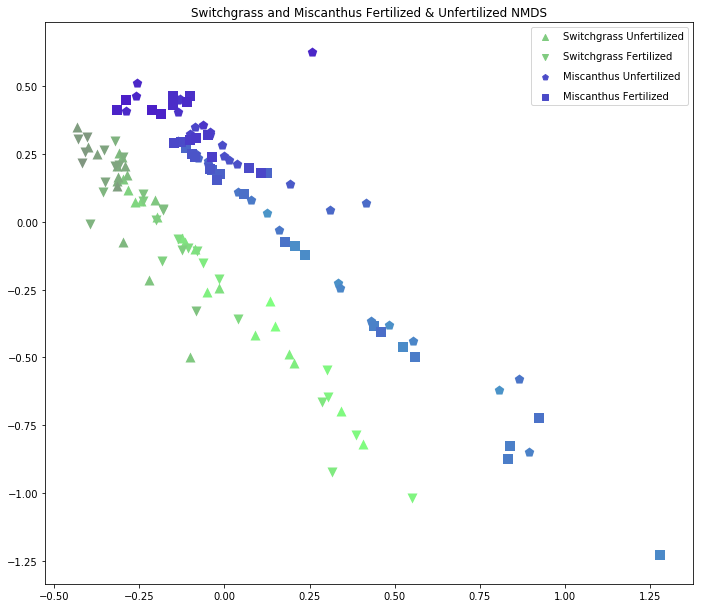

In [7]:
import matplotlib as mpl
fig = plt.figure(1)
ax = plt.axes([0., 0., 1.5, 1.95])
s = 100
index = 0
totalGroups = nsamples/4
l1s, l2s = [], []
dateColors = []
for sample in sortedmeta.index:
#     print(sample)
    if sortedmeta[sortedmeta.index == sample].type[0] == "G5": 
        species = "SG"
        if sortedmeta[sortedmeta.index == sample].treatment[0] == "nitrogen free": 
            treatment = "NF"
            marker = '^'
        else: 
            treatment = "Fert"
            marker= "v"
    else: 
        species = "MC"; 
        if sortedmeta[sortedmeta.index == sample].treatment[0] == "nitrogen free": 
            treatment = "NF"
            marker = 'p'
        else: 
            treatment = "Fert"
            marker= "s"
    lbl = "%s_%s" % (species,treatment)
    date=sortedmeta[sortedmeta.index == sample].Date[0]
    dateColors.append(scolor(index,72,species == "SG"))
    plt.scatter(npos[index:index+1, 0], npos[index:index+1, 1], color=scolor(index,72,species == "SG"), s=s, lw=0,label=None,cmap='viridis',marker=marker)
    index += 1

for crop,marker in [['Switchgrass Unfertilized','^'],['Switchgrass Fertilized','v'],['Miscanthus Unfertilized','p'],['Miscanthus Fertilized','s'],]:
    midval = 63/2
    if "Switchgrass" not in crop: midval = 72 + 72/2
    print(crop, scolor(midval,72, "SG" in crop))
    plt.scatter([], [], c=scolor(midval,72, "Switchgrass" in crop), label=crop, marker=marker)
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='')
#handles, labels = ax.get_legend_handles_labels()
# plt.axis(aspect='equal')
#cmap = mpl.colors.ListedColormap(dateColors)
#cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, orientation='vertical')
#cb1.set_label('Some Units')
#psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
#fig.colorbar(cmap, ax=ax)
#plt.colorbar(cmap, label='Time')
# plt.clim(3, 7)
# sort both labels and handles by labels
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
# ax.legend(handles, labels)
#plt.legend(handles, labels,scatterpoints=1, loc='best', shadow=False)
plt.title("Switchgrass and Miscanthus Fertilized & Unfertilized NMDS")
# # plt.tight_layout()
plt.savefig("figures/AllCombinedNMDS_genes.png",bbox_inches='tight')
plt.show()

In [6]:
allCounts = allCounts.transpose()
allCounts.to_csv("stats/filteredCountTable.tsv",sep='\t')        

In [34]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
newcolors[:25, :] = pink
newcmp = ListedColormap(newcolors)

# Look at annotations

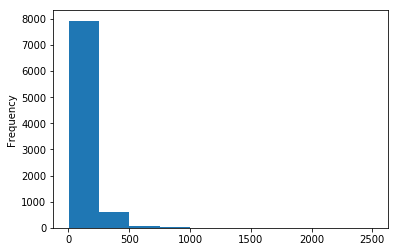

In [8]:
annoMap = {}
revMap = {}
for line in open("annotations/annotationDescripts.tsv"):
    contID, function = line.strip().split("\t")
#     if contID in annoMap:
#         print(contID,function,annoMap[contID])
#         break
    annoMap[contID]= function
    try:revMap[function].add(contID)
    except:revMap[function] = set([contID])
dist = {}
for function,contigs in revMap.items():
    dist[function]=len(contigs)
dist = Series(dist)
dist.plot.hist();
dump(revMap,open("pickles/functionMap.p","wb"))
dump(annoMap,open("pickles/annoMap.p","wb"))

In [4]:
dist[dist>900]

3-oxoacyl-[acyl-carrier-protein] reductase FabG                    2505
Serine/threonine-protein kinase PrkC                               1893
Chromosome partition protein Smc                                   1406
Chaperone protein DnaJ                                             1372
putative HTH-type transcriptional regulator                        1084
Chaperone protein DnaK                                              976
putative oxidoreductase                                            1964
Blue-light-activated histidine kinase                               955
ATP-dependent zinc metalloprotease FtsH                            1443
putative signaling protein                                         2405
Tyrosine recombinase XerC                                          1270
Sensor kinase CckA                                                  978
Long-chain-fatty-acid--CoA ligase                                   920
Bifunctional protein                                            

In [16]:
allCounts.head()

,G5R1_NF_09MAY2016_LD1,G5R2_NF_09MAY2016_LD1,G5R3_NF_09MAY2016_LD1,G5R4_NF_09MAY2016_LD1,G5R1_MAIN_09MAY2016_LD1,G5R2_MAIN_09MAY2016_LD1,G5R3_MAIN_09MAY2016_LD1,G5R4_MAIN_09MAY2016_LD1,G5R1_NF_31MAY2016_LD1,G5R2_NF_31MAY2016_LD1,...,G6R3_MAIN_03OCT2016_LD1,G6R4_MAIN_03OCT2016_LD1,G6R1_NF_07NOV2016_LD1,G6R2_NF_07NOV2016_LD1,G6R3_NF_07NOV2016_LD1,G6R4_NF_07NOV2016_LD1,G6R1_MAIN_07NOV2016_LD1,G6R2_MAIN_07NOV2016_LD1,G6R3_MAIN_07NOV2016_LD1,G6R4_MAIN_07NOV2016_LD1
k127_10000253_2749_5290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
k127_1000030_1707_3210,0,0,0,0,0,0,0,0,0,0,...,0,2,2,8,2,0,6,0,4,0
k127_1000030_763_1681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4,4,2,6,0,6,2
k127_10000569_431_989,0,0,0,0,0,0,0,0,0,0,...,2,2,8,2,12,4,6,0,0,4
k127_10000650_141_1335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
revMap = load(open("pickles/functionMap.p","rb"))
list(revMap.keys())[:10]

In [ ]:
from pickle import load,dump
allCounts = load(open("pickles/allCounts_genes.p","rb"))
annoMap = load(open("pickles/annoMap.p","rb"))
revMap = load(open("pickles/functionMap.p","rb"))

excCounter = 0
geneCounts = {}
for index,sample in enumerate(allCounts.columns):
    geneCounts[sample]={}
    sampleCounts = allCounts[sample]
    print("%i. %s" % (index+1,sample))
    for function,contigs in revMap.items():
        functCounts = sampleCounts[sampleCounts.index.isin(contigs)]
        nReads = float(functCounts.sum(axis = 0))
        geneCounts[sample][function] = nReads
#         try: geneCounts[sample][function] = nReads/len(functCounts)
#         except:
#             excCounter +=1
#             geneCounts[sample][function] = 0.0
dump(geneCounts,open("pickles/pooledGeneCounts.p","wb"))
print("There were %i genes with no representative contigs" % (excCounter))

1. G5R1_NF_09MAY2016_LD1
2. G5R2_NF_09MAY2016_LD1
3. G5R3_NF_09MAY2016_LD1
4. G5R4_NF_09MAY2016_LD1
5. G5R1_MAIN_09MAY2016_LD1
6. G5R2_MAIN_09MAY2016_LD1
7. G5R3_MAIN_09MAY2016_LD1
8. G5R4_MAIN_09MAY2016_LD1
9. G5R1_NF_31MAY2016_LD1
10. G5R2_NF_31MAY2016_LD1
11. G5R3_NF_31MAY2016_LD1
12. G5R4_NF_31MAY2016_LD1


In [3]:
geneCounts = DataFrame(load(open("pickles/pooledGeneCounts.p","rb")))
print(len(geneCounts))

8630


In [ ]:
geneCounts.to_csv("tables/GeneCounts.tsv",sep='\t')

In [10]:
df = DataFrame(geneCounts)
remove = set()

for function in df.index:
    functionCount = float(df[df.index == function].sum(axis=1)) 
    if(functionCount == 0.0): remove.add(function)
print(len(remove))
df.drop(remove,inplace=True)

2471


In [11]:
df.head()

,G5R1_NF_09MAY2016_LD1,G5R2_NF_09MAY2016_LD1,G5R3_NF_09MAY2016_LD1,G5R4_NF_09MAY2016_LD1,G5R1_MAIN_09MAY2016_LD1,G5R2_MAIN_09MAY2016_LD1,G5R3_MAIN_09MAY2016_LD1,G5R4_MAIN_09MAY2016_LD1,G5R1_NF_31MAY2016_LD1,G5R2_NF_31MAY2016_LD1,...,G6R3_MAIN_03OCT2016_LD1,G6R4_MAIN_03OCT2016_LD1,G6R1_NF_07NOV2016_LD1,G6R2_NF_07NOV2016_LD1,G6R3_NF_07NOV2016_LD1,G6R4_NF_07NOV2016_LD1,G6R1_MAIN_07NOV2016_LD1,G6R2_MAIN_07NOV2016_LD1,G6R3_MAIN_07NOV2016_LD1,G6R4_MAIN_07NOV2016_LD1
(-)-trans-carveol dehydrogenase,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,8.000000,6.000000,5.000000,15.000000,14.000000,8.000000,16.000000,6.000000,15.000000
"(2E,6E)-farnesyl diphosphate synthase",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,4.000000,16.666667,10.333333,13.000000,6.000000,21.333333,12.666667,10.333333,23.333333
(2R)-3-sulfolactate dehydrogenase (NADP(+)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,2.333333,13.000000,30.000000,84.333333,22.000000,17.000000,18.000000,13.000000,19.333333
(2R)-sulfolactate sulfo-lyase subunit beta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500000,5.250000,15.750000,19.250000,69.250000,22.500000,16.750000,17.750000,8.500000,18.250000
(2S)-methylsuccinyl-CoA dehydrogenase,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.000000,4.461538,26.307692,41.384615,87.076923,36.153846,26.153846,25.846154,20.769231,31.076923


In [23]:
distlist = []
for function in df.index:distlist.append(float(df[df.index == function].sum(axis=1)))

count    6091.000000
mean      321.342460
std       151.590797
min       138.000000
25%       231.500000
50%       290.842105
75%       370.328829
max      2148.058252
dtype: float64

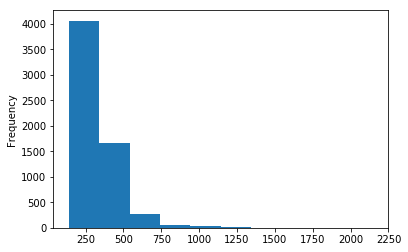

In [33]:
dist = Series(distlist)
dist = dist[dist < dist.mean()*.001*dist.std()]
dist.plot.hist()
dist.describe()

In [14]:
diamondAnnos = {}
for line in open("KEGG_tools_out/diamondAnnotations_0_KOtable.txt"):
    rec = line.split("\t")
    try: diamondAnnos[rec[0]].add(rec[2])
    except:  diamondAnnos[rec[0]] = set([rec[2]])
print(len(diamondAnnos))

521886


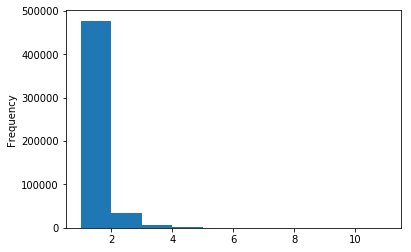

In [17]:
dist,conts = [],[]
for contID, KOList in diamondAnnos.items(): conts.append(contID); dist.append(len(KOList))
dist = Series(dist,index=conts)
dist.plot.hist()

In [21]:
len(dist[dist>=2])/float(len(dist))

0.0858827406751666

In [24]:
allCounts = load(open("pickles/allCounts_genes.p","rb"))

In [70]:
medianReplicateGeneCounts = {}
for crop in set(metadata.type):
    for date in set(metadata.sampling_date):
        for treatment in set(metadata.treatment):
            replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(replicateSamples) == 0: continue
#             print(crop,date,treatment)
            replicateCounts = geneCounts[list(replicateSamples.nucleic_acid_name)]
            groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
            medianReplicateGeneCounts[groupID] = replicateCounts.median(axis=1)
            #             
#             sampleGroup[groupID] = {}
#             for function, contigList in revMap.items():
#                 functionCounts = sampleCounts[sampleCounts.index.isin(contigList)]
#                 sampleGroup[groupID][function] = functionCounts.sum().median()
medianReplicateGeneCounts = DataFrame(medianReplicateGeneCounts)
medianReplicateGeneCounts.head()

,G5_NF_20JUN2016_LD1,G5_MAIN_20JUN2016_LD1,G5_NF_09MAY2016_LD1,G5_MAIN_09MAY2016_LD1,G5_NF_03OCT2016_LD1,G5_MAIN_03OCT2016_LD1,G5_NF_31MAY2016_LD1,G5_MAIN_31MAY2016_LD1,G5_NF_12JUL2016_LD1,G5_MAIN_12JUL2016_LD1,...,G6_NF_12JUL2016_LD1,G6_MAIN_12JUL2016_LD1,G6_NF_01AUG2016_LD1,G6_MAIN_01AUG2016_LD1,G6_NF_22AUG2016_LD1,G6_MAIN_22AUG2016_LD1,G6_NF_12SEP2016_LD1,G6_MAIN_12SEP2016_LD1,G6_NF_07NOV2016_LD1,G6_MAIN_07NOV2016_LD1
"(+)-T-muurolol synthase ((2E,6E)-farnesyl diphosphate cyclizing)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(+)-eremophilene synthase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(-)-gamma-cadinene synthase ((2Z,6E)-farnesyl diphosphate cyclizing)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(-)-trans-carveol dehydrogenase,0.0,0.0,0.0,0.0,7.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.5,10.000000,11.5
"(2E,6E)-farnesyl diphosphate synthase",0.0,0.0,0.0,0.0,10.5,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.833333,3.0,11.666667,17.0


In [76]:
remove = set()
for function in medianReplicateGeneCounts.index:
    if medianReplicateGeneCounts[medianReplicateGeneCounts.index == function].sum(axis=1).sum()== 0:remove.add(function)
len(remove)

2471

In [78]:
print(medianReplicateGeneCounts.shape)
medianReplicateGeneCounts.drop(remove,inplace=True)
print(medianReplicateGeneCounts.shape)

(8630, 34)
(6159, 34)


In [ ]:
dump(sampleGroup,open("pickles/deepFunctionReplicateCounts.p","wb"))

In [77]:
medianReplicateGeneCounts.shape

(8630, 34)

In [92]:
dates=metadata[["sampling_date","Date","nucleic_acid_name"]]
dates=dates.sort_values(by="Date")
dates=dates[["sampling_date","nucleic_acid_name"]]

In [93]:
metadata = metadata.sort_values(by="Date")

Index(['sampling_date', 'nucleic_acid_name'], dtype='object')

In [148]:
metadata.treatment.unique()

array(['nitrogen free', 'standard fertilization'], dtype=object)

In [153]:
persistent = set()
crop ="G5"
treatment = 'standard fertilization'
prevTimePoint = []
seenGenes =set()
for crop in metadata.type.unique():
    for treatment in metadata.treatment.unique():
        for date in dates.sampling_date.unique():
            replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(replicateSamples) == 0: continue
            groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
            if len(prevTimePoint) == 0:
                prevTimePoint = medianReplicateGeneCounts[groupID]
                prevTimePoint = prevTimePoint[prevTimePoint>0]
                persistent = set(prevTimePoint.index)
        #         print("There are %i genes present at start %s" % (len(prevTimePoint),str(date)))
                continue
            curTimePoint = medianReplicateGeneCounts[groupID]
            curTimePoint = curTimePoint[curTimePoint>0]
        #     print("At the next time point %s there are %i genes"%(str(date),len(curTimePoint)))
        #     print("\t%i genes existed in the last timepoint" % (len(set(curTimePoint.index).intersection(prevTimePoint.index))))
        #     print("\t%i genes are new" % (len(set(curTimePoint.index).difference(prevTimePoint.index))))
            seenGenes = seenGenes.union(set(curTimePoint.index).union(prevTimePoint.index))
        #     print("\t%i genes so far\n" % (len(seenGenes)))
            persistent = persistent.intersection(curTimePoint.index)
            prevTimePoint = curTimePoint
        print("There are %i genes that persist over time for %s with %s" % (len(persistent),crop,treatment))
        persIncreasing = persistent
        persDecreasing = persistent
        prevTimePoint = []
        seenGenes =set()
        for i,date in enumerate(dates.sampling_date.unique()):
            replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(replicateSamples) == 0: continue
            groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
            if len(prevTimePoint) == 0:
                prevTimePoint = medianReplicateGeneCounts[groupID]
                prevTimePointDec = prevTimePoint[prevTimePoint.index.isin(persistent)]
                prevTimePointInc = prevTimePoint[prevTimePoint.index.isin(persistent)]
                continue
            prevTimePointInc = prevTimePointInc[prevTimePointInc.index.isin(persIncreasing)]
            prevTimePointDec = prevTimePointDec[prevTimePointDec.index.isin(persDecreasing)]
            curTimePoint = medianReplicateGeneCounts[groupID]
            curIncreasing = curTimePoint[curTimePoint.index.isin(persIncreasing)]
            curDecreasing = curTimePoint[curTimePoint.index.isin(persDecreasing)]
            increasing = curIncreasing[curIncreasing >= prevTimePointInc]
            decreasing = curDecreasing[curDecreasing <= prevTimePointDec]
            persIncreasing = set(increasing.index)
            persDecreasing = set(decreasing.index)
            print("\tAt time %s \t %i genes are still increasing\t" % (str(date), len(persIncreasing)),end='\t')
            print("%i genes are still decreasing" % ( len(persDecreasing)))
            
            #Add normalization by number of reads

There are 998 genes that persist over time for G5 with nitrogen free
	At time 5/31/16 	 903 genes are still increasing		139 genes are still decreasing
	At time 6/20/16 	 840 genes are still increasing		77 genes are still decreasing
	At time 7/12/16 	 822 genes are still increasing		68 genes are still decreasing
	At time 8/1/16 	 821 genes are still increasing		56 genes are still decreasing
	At time 8/22/16 	 801 genes are still increasing		51 genes are still decreasing
	At time 9/12/16 	 800 genes are still increasing		46 genes are still decreasing
	At time 10/3/16 	 757 genes are still increasing		43 genes are still decreasing
There are 955 genes that persist over time for G5 with standard fertilization
	At time 5/31/16 	 817 genes are still increasing		173 genes are still decreasing
	At time 6/20/16 	 770 genes are still increasing		115 genes are still decreasing
	At time 7/12/16 	 761 genes are still increasing		95 genes are still decreasing
	At time 8/1/16 	 752 genes are still inc

In [154]:
for i,date in enumerate(dates.sampling_date.unique()):print(date)

5/9/16
5/31/16
6/20/16
7/12/16
8/1/16
8/22/16
9/12/16
10/3/16
11/7/16


In [146]:
persistent = set()
crop ="G6"
prevTimePoint = []
seenGenes =set()
for date in dates.sampling_date.unique():
    replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
    if len(replicateSamples) == 0: continue
    groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
    if len(prevTimePoint) == 0:
        prevTimePoint = medianReplicateGeneCounts[groupID]
        prevTimePoint = prevTimePoint[prevTimePoint>0]
        persistent = set(prevTimePoint.index)
        print("There are %i genes present at start %s" % (len(prevTimePoint),str(date)))
        continue
    curTimePoint = medianReplicateGeneCounts[groupID]
    curTimePoint = curTimePoint[curTimePoint>0]
    print("At the next time point %s there are %i genes"%(str(date),len(curTimePoint)))
    print("\t%i genes existed in the last timepoint" % (len(set(curTimePoint.index).intersection(prevTimePoint.index))))
    print("\t%i genes are new" % (len(set(curTimePoint.index).difference(prevTimePoint.index))))
    seenGenes = seenGenes.union(set(curTimePoint.index).union(prevTimePoint.index))
    print("\t%i genes so far\n" % (len(seenGenes)))
    persistent = persistent.intersection(curTimePoint.index)
    prevTimePoint = curTimePoint
print("There are %i genes that persist over time" % (len(persistent)))

There are 1006 genes present at start 5/9/16
At the next time point 5/31/16 there are 1265 genes
	945 genes existed in the last timepoint
	320 genes are new
	1326 genes so far

At the next time point 6/20/16 there are 2884 genes
	1224 genes existed in the last timepoint
	1660 genes are new
	2937 genes so far

At the next time point 7/12/16 there are 2547 genes
	2153 genes existed in the last timepoint
	394 genes are new
	3300 genes so far

At the next time point 8/1/16 there are 3660 genes
	2383 genes existed in the last timepoint
	1277 genes are new
	4046 genes so far

At the next time point 8/22/16 there are 4744 genes
	3611 genes existed in the last timepoint
	1133 genes are new
	4913 genes so far

At the next time point 9/12/16 there are 5082 genes
	4550 genes existed in the last timepoint
	532 genes are new
	5384 genes so far

At the next time point 10/3/16 there are 5335 genes
	4903 genes existed in the last timepoint
	432 genes are new
	5643 genes so far

At the next time point 

### What genes consistently go up over time?

In [139]:
persIncreasing = persistent
persDecreasing = persistent

In [145]:
# persistent
persIncreasing = persistent
persDecreasing = persistent
prevTimePoint = []
seenGenes =set()
print(crop,treatment)
for i,date in enumerate(dates.sampling_date.unique()):
    replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
    if len(replicateSamples) == 0: continue
    groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
#     print(groupID)
    if len(prevTimePoint) == 0:
        prevTimePoint = medianReplicateGeneCounts[groupID]
        prevTimePointDec = prevTimePoint[prevTimePoint.index.isin(persistent)]
        prevTimePointInc = prevTimePoint[prevTimePoint.index.isin(persistent)]
        continue
    
    prevTimePointInc = prevTimePointInc[prevTimePointInc.index.isin(persIncreasing)]
    prevTimePointDec = prevTimePointDec[prevTimePointDec.index.isin(persDecreasing)]
    curTimePoint = medianReplicateGeneCounts[groupID]
    curIncreasing = curTimePoint[curTimePoint.index.isin(persIncreasing)]
    curDecreasing = curTimePoint[curTimePoint.index.isin(persDecreasing)]
    increasing = curIncreasing[curIncreasing >= prevTimePointInc]
    decreasing = curDecreasing[curDecreasing <= prevTimePointDec]
    persIncreasing = set(increasing.index)
    persDecreasing = set(decreasing.index)
    print("At time %i - %i genes are still increasing" % (i, len(persIncreasing)),end='\t')
    print("At time %i - %i genes are still decreasing" % (i, len(persDecreasing)))
        

G5 nitrogen free
At time 1 - 903 genes are still increasing	At time 1 - 139 genes are still decreasing
At time 2 - 840 genes are still increasing	At time 2 - 77 genes are still decreasing
At time 3 - 822 genes are still increasing	At time 3 - 68 genes are still decreasing
At time 4 - 821 genes are still increasing	At time 4 - 56 genes are still decreasing
At time 5 - 801 genes are still increasing	At time 5 - 51 genes are still decreasing
At time 6 - 800 genes are still increasing	At time 6 - 46 genes are still decreasing
At time 7 - 757 genes are still increasing	At time 7 - 43 genes are still decreasing


In [147]:
persIncreasing = persistent
persDecreasing = persistent
prevTimePoint = []
seenGenes =set()
print(crop,treatment)
for i,date in enumerate(dates.sampling_date.unique()):
    replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
    if len(replicateSamples) == 0: continue
    groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
#     print(groupID)
    if len(prevTimePoint) == 0:
        prevTimePoint = medianReplicateGeneCounts[groupID]
        prevTimePointDec = prevTimePoint[prevTimePoint.index.isin(persistent)]
        prevTimePointInc = prevTimePoint[prevTimePoint.index.isin(persistent)]
        continue
    
    prevTimePointInc = prevTimePointInc[prevTimePointInc.index.isin(persIncreasing)]
    prevTimePointDec = prevTimePointDec[prevTimePointDec.index.isin(persDecreasing)]
    curTimePoint = medianReplicateGeneCounts[groupID]
    curIncreasing = curTimePoint[curTimePoint.index.isin(persIncreasing)]
    curDecreasing = curTimePoint[curTimePoint.index.isin(persDecreasing)]
    increasing = curIncreasing[curIncreasing >= prevTimePointInc]
    decreasing = curDecreasing[curDecreasing <= prevTimePointDec]
    persIncreasing = set(increasing.index)
    persDecreasing = set(decreasing.index)
    print("At time %i - %i genes are still increasing" % (i, len(persIncreasing)),end='\t')
    print("At time %i - %i genes are still decreasing" % (i, len(persDecreasing)))
        

G6 nitrogen free
At time 1 - 490 genes are still increasing	At time 1 - 529 genes are still decreasing
At time 2 - 380 genes are still increasing	At time 2 - 229 genes are still decreasing
At time 3 - 376 genes are still increasing	At time 3 - 71 genes are still decreasing
At time 4 - 339 genes are still increasing	At time 4 - 51 genes are still decreasing
At time 5 - 339 genes are still increasing	At time 5 - 24 genes are still decreasing
At time 6 - 338 genes are still increasing	At time 6 - 17 genes are still decreasing
At time 7 - 338 genes are still increasing	At time 7 - 14 genes are still decreasing
At time 8 - 327 genes are still increasing	At time 8 - 9 genes are still decreasing


In [112]:
startTime = medianReplicateGeneCounts['G5_NF_09MAY2016_LD1']
startTime = startTime[startTime > 0]
print(len(startTime))
startTime.index

1090


Index(['(2Z,6E)-farnesyl diphosphate synthase',
       '(R)-specific enoyl-CoA hydratase', '(S)-mandelate dehydrogenase',
       '1,2-phenylacetyl-CoA epoxidase, subunit E',
       '1,3,6,8-tetrahydroxynaphthalene synthase',
       '1,4-alpha-glucan branching enzyme GlgB',
       '1,4-beta-D-glucan glucohydrolase',
       '1,4-dihydroxy-2-naphthoyl-CoA synthase',
       '1,5-anhydro-D-fructose reductase',
       '1-deoxy-D-xylulose 5-phosphate reductoisomerase',
       ...
       'tRNA N6-adenosine threonylcarbamoyltransferase',
       'tRNA dimethylallyltransferase', 'tRNA modification GTPase MnmE',
       'tRNA pseudouridine synthase A', 'tRNA pseudouridine synthase B',
       'tRNA-2-methylthio-N(6)-dimethylallyladenosine synthase',
       'tRNA-binding protein YgjH', 'tRNA-dihydrouridine synthase B',
       'tRNA-dihydrouridine(16) synthase',
       'tRNA-specific adenosine deaminase'],
      dtype='object', length=1090)

In [144]:
curTimePoint[curTimePoint.index.isin(persDecreasing)]

30S ribosomal protein S11                                   18.400000
30S ribosomal protein S18                                   37.666667
30S ribosomal protein S19                                    6.800000
30S ribosomal protein S2                                    20.820000
30S ribosomal protein S3                                    19.400000
30S ribosomal protein S4                                    17.125000
50S ribosomal protein L14                                   12.000000
50S ribosomal protein L22                                   15.800000
50S ribosomal protein L32                                    2.500000
ATP synthase subunit a                                      19.202381
ATP synthase subunit alpha                                  30.500000
ATP synthase subunit beta                                   28.000000
ATP synthase subunit c                                       5.333333
ATP-dependent Clp protease proteolytic subunit              15.479167
Cytochrome b6-f comp

In [ ]:
seqMappedDist = Series(load(open("pickles/seqMappedCounter.p","rb")))

In [ ]:
from Bio.SeqIO import parse, write
from Bio.SeqRecord import SeqRecord
annotatedRegions = open("assemblies/assemblyGeneSeqs.fa","w")
geneDescripts = open("annotations/annotationDescripts.tsv","w")
annotations = glob("annotations/prokka/final.contigs.*/*.gbk")
for fname in annotations:
    print(fname)    
    for rec in parse(fname,'genbank'):
        for feature in rec.features:
            try:
                product = feature.qualifiers['product'][0]
                if product == "hypothetical protein":continue
                subSeq = rec.seq[feature.location.start:feature.location.end]
                seqID = "%s_%i_%i" % (rec.id,feature.location.start,feature.location.end)
                newSeq = SeqRecord(subSeq,seqID,'','')
                geneDescripts.write("%s\t%s\n" % (seqID,product))
                write(newSeq,annotatedRegions,"fasta")
            except:pass
annotatedRegions.close()

In [ ]:
presenceDist=presenceDist/float(numSamples)

In [ ]:
#fh = open("assemblies/parts/final.contigs.%i.fa" % (index),"w")
from Bio.SeqIO import parse, write
counter,index = 0, 0
for rec in parse("assemblies/final.contigs.fa","fasta"): 
    if counter % 500000 == 0:
        #fh.close()
        index += 1
        print(index,end=" ")
        #fh = open("assemblies/parts/final.contigs.%i.fa" % (index),"w")
    #write(rec,fh,"fasta")
    counter+=1
#fh.close()     

In [ ]:
%%bash
#ls -laht pickles
#head stats/11425.5.206700.GCCTTGT-AACAAGG.fastq.gz.tsv

In [ ]:
#Initialize the dictionary for the counts
seqCounter = {} #load(open("pickles/seqCounter.p","rb"))
combined_abundance = seqCounter.copy()
for crop in set(metadata.type):
    for date in set(metadata.sampling_date):
        for treatment in set(metadata.treatment):
            sampleGroupMeta = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(sampleGroupMeta) == 0: continue
            sampleAbundance = seqCounter.copy()
            samplePresence = seqCounter.copy()
            comFileName = "stats/combined/%s_%s.tsv" % (sampleGroupMeta.plot_name.unique()[0],date.replace("/","_"))
            print(comFileName)
            outfile = open(comFileName, "w")
            nfiles = 4
            for fstaName in sampleGroupMeta.index:
                try:
                    with open("stats/%s.tsv" % (fstaName)) as fh:
                        for line in fh:
                            rec = line.strip().split()
                            sampleAbundance[rec[0]] += int(rec[2])
                            samplePresence[rec[0]]  += int(int(rec[2])>0)
                except:
                    print("\t\t",comFileName,"is missing file:",fstaName)
                    missingStats.append(fstaName)
                    nfiles-=1
                    
            contigCounter = 0
            for contName,presCount in samplePresence.items():
                contigCounter += int(presCount >= 2)
                outfile.write("%s\t%s\n" % (contName,int(sampleAbundance[contName]/nfiles)))
                combined_abundance[contName] += int(sampleAbundance[contName]/nfiles)
            print("\t",contigCounter,"Contigs Present")
            outfile.close()
dump(combined_abundance,open("pickles/combined_abundance.p","wb"))
dump(missingStats,open("pickles/missingStats.p","wb"))

<h3><a id="pltao">Plot abundance and occupancy</a></h3>

In [ ]:
# Now that the files are combined, let's look at p/a and abundance
fileNames = glob("stats/combined/*.tsv")
presAbs,abundance = {},{}
for fname in fileNames:
    print(fname)
    for line in open(fname): 
        rec = line.strip().split()
        try:presAbs[rec[0]] += int(int(rec[1]) > 0)
        except:presAbs[rec[0]] = int(int(rec[1]) > 0)
        try:abundance[rec[0]] += int(rec[1])
        except:abundance[rec[0]] = int(rec[1])

dump(presAbs,open("presence_absence_combined.p","wb"))    
dump(abundance,open("abundance_combined.p","wb"))   
dist_pres = []
numSamples = float(len(fileNames))
for contig, count in presAbs.items(): dist_pres.append(count/float(numSamples))
plotter = Series(dist_pres)
plotter.plot.hist();

<h3><a id="pltao">Abundance</a></h3>

In [ ]:
# combinedFiles = glob("stats/combined/filtered/*.tsv")
# presAbs = load(open("pickles/presence_absence_combined.p","rb"))    
# abundance = load(open("pickles/abundance_combined.p","rb"))   
# dist_pres = []
# numSamples = float(len(combinedFiles))
# for contig, count in presAbs.items(): dist_pres.append(count/float(numSamples))
# plotter = Series(dist_pres)
ax = plotter.plot.hist()  # s is an instance of Series
fig = ax.get_figure()
fig.savefig('figures/Abundance_combined.png')
ax;

<h3><a id="OXA">Occupancy X Abundance</a></h3>

In [ ]:
import matplotlib.pyplot as plt
xs, ys =[], []
for i in range(1,1000):
    xs.append(i/1000.0)
    ys.append(len(plotter[plotter > i/1000.0]))
plt.plot(xs,ys)
plt.xlabel('Percent of samples',fontsize=14)
plt.ylabel('Rank Abundance',fontsize=14)
plt.savefig("figures/OccupencyAbundance.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
xs, ys =[], []
for contName in presAbs:
    ys.append(presAbs[contName]/numSamples)
    xs.append(abundance[contName])
plt.plot(xs,ys,'ro')
plt.xlabel('Abundance',fontsize=14)
plt.ylabel('% Presence',fontsize=14)
plt.show()

<h2><a id="pltao">Filter the data by occupency and abundance</a></h2>

In [ ]:
numSamples = float(len(fileNames))
# keeperContigs = set()
# for contig, count in presAbs.items(): 
#     if count/float(numSamples) >= .25: keeperContigs.add(contig)
print ("Keeping %i contigs" % (len(keeperContigs)))

fileNames = glob("stats/combined/*.tsv")
presAbs,abundance = {},{}

print("%i combined samples"%(int(numSamples)))
counter=0
for fname in fileNames:
    counter += 1
    print("%i." % counter,fname)
    ffh =  open(fname.replace("stats/combined/","stats/combined/filtered/"),"w")
    for line in open(fname): 
        rec = line.strip().split()
        if rec[0] in keeperContigs: 
            ffh.write("%s\t%s\n" % (rec[0],rec[1]))
            try:presAbs[rec[0]]     += int(int(rec[1]) > 0)
            except:presAbs[rec[0]]   = int(int(rec[1]) > 0)
            try:abundance[rec[0]]   += int(rec[1])
            except:abundance[rec[0]] = int(rec[1])
    ffh.close()
    
import matplotlib.pyplot as plt
xs, ys =[], []
for contName in presAbs:
    xs.append(presAbs[contName]/numSamples)
    ys.append(abundance[contName])
plt.plot(xs,ys,'ro')
plt.xlabel('Percent Abundance',fontsize=14)
plt.ylabel('Abundance',fontsize=14)
plt.show()


In [ ]:
fileNames = glob("stats/combined/filtered/*.tsv")
allCounts = {}
counter=0
for fname in fileNames:
    sampleName = fname.replace("stats/combined/filtered/","").replace(".tsv","")
    allCounts[sampleName]={}
    counter+=1
    print("%i. %s"%(counter,sampleName))
    for line in open(fname):
        rec=line.strip().split()
        allCounts[sampleName][rec[0]]=int(rec[1])
dump(allCounts,open("pickles/sampleDict.p","wb"))    

<h2><a id="nmds">NMDS</a></h2>

In [ ]:
sampleOrder = {}
counter = 0
dates=metadata[["sampling_date","Date"]]
dates=dates.sort_values(by="Date")
dates=dates["sampling_date"]
    
for date in dates.unique():
    for crop in set(metadata.type):
        for treatment in set(metadata.treatment):
            sampleGroupMeta = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(sampleGroupMeta) == 0: continue
            idName = "%s_%s" % (sampleGroupMeta.plot_name.unique()[0],date.replace("/","_"))
            counter+=1
            sampleOrder[idName] = counter

print("Loading sample counts")
allCounts = load(open("pickles/sampleDict.p","rb"))
allCounts = DataFrame(allCounts).transpose()
allCounts['Rank'] = allCounts.index.to_series().map(sampleOrder)
allCounts.sort_values('Rank',inplace = True)
allCounts.drop('Rank', 1, inplace = True)
allCounts.head()

In [ ]:
seed = np.random.RandomState(seed=3)
allCounts_matrix = allCounts.as_matrix()
similarities = euclidean_distances(allCounts_matrix)

nsamples = len(allCounts)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

fig = plt.figure(1)
ax = plt.axes([0., 0., 1.5, 1.95])
s = 100
counter = 0
group = 0
totalGroups = nsamples/4
l1s, l2s = [], []
for date in dates.unique():
    group+=1
    l1s.append("SG-Fert "+date)
    plt.scatter(npos[counter:counter+1, 0], npos[counter:counter+1, 1], color=scolor(group,totalGroups,True), s=s, lw=0, label="SG-Fert "+date,marker="^")
    counter+=1
    l1s.append("SG-NF "+date)
    plt.scatter(npos[counter:counter+1, 0], npos[counter:counter+1, 1], color=scolor(group,totalGroups,True), s=s, lw=0, label="SG-NF "+date,marker="v")
    counter+=1
    l2s.append("MC-Fert "+date)
    plt.scatter(npos[counter:counter+1, 0], npos[counter:counter+1, 1], color=scolor(group,totalGroups,False), s=s, lw=0, label="MC-Fert "+date,marker="p")
    counter+=1
    l2s.append("MC-NF "+date)
    plt.scatter(npos[counter:counter+1, 0], npos[counter:counter+1, 1], color=scolor(group,totalGroups,False), s=s, lw=0, label="MC-NF "+date,marker="H")
    counter+=1

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
# ax.legend(handles, labels)
plt.legend(handles, labels,scatterpoints=1, loc='best', shadow=False)
plt.title("Switchgrass(SG) and Miscanthus(MC) Fertilized(Fert) & Not Ferilized(NF) NMDS")
# plt.tight_layout()
plt.savefig("figures/AllCombinedNMDS.png",bbox_inches='tight')
plt.show()

In [12]:
g6Data, g5Data = [],[]
for key in allCounts.index:
    if key[:2] == "G5": g5Data.append(key)
    else: g6Data.append(key)
g5Data = allCounts.drop(g5Data)
g6Data = allCounts.drop(g6Data)

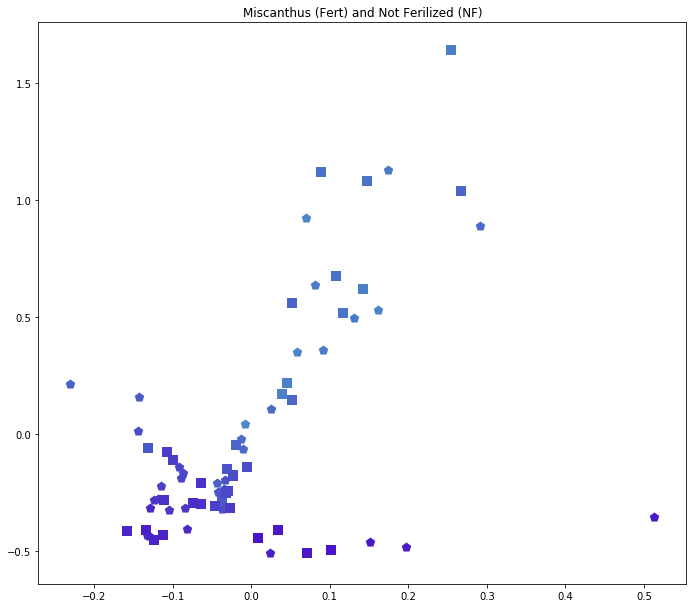

In [25]:
g5Data_matrix = g5Data.as_matrix()
similarities = euclidean_distances(g5Data_matrix)
nsamples = len(g5Data)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

fig = plt.figure(1)
ax = plt.axes([0., 0., 1.5, 1.95])
s = 100

for index, sample in enumerate(g5Data.index):
    species = "MC"; 
    if sortedmeta[sortedmeta.nucleic_acid_name == sample].treatment[0] == "nitrogen free": 
        treatment = "NF"
        marker = 'p'
    else: 
        treatment = "Fert"
        marker= "s"
            
    lbl = "%s_%s" % (species,treatment)
    plt.scatter(npos[index:index+1, 0], npos[index:index+1, 1], color=scolor(index+71,72,species == "SG"), s=s, lw=0, label=lbl,marker=marker)

#plt.legend(scatterpoints=1, loc='best', shadow=False)
plt.title("Miscanthus (Fert) and Not Ferilized (NF)")
plt.savefig("figures/Miscanthus_NMDS_genes.png", bbox_inches='tight')
plt.show()

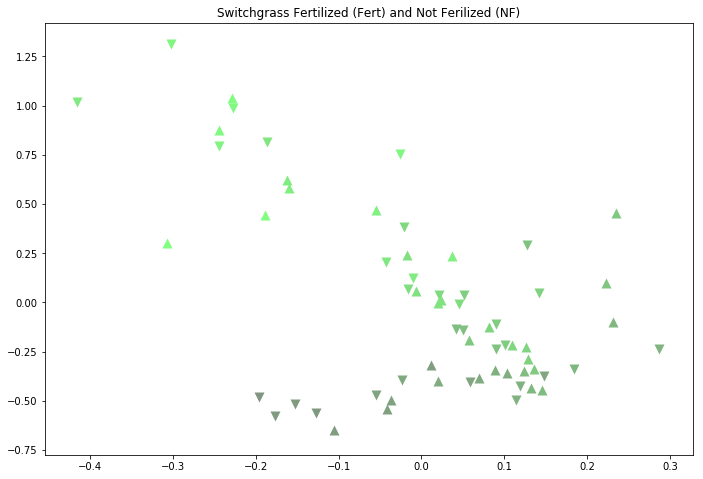

In [27]:
g6Data_matrix = g6Data.as_matrix()
similarities = euclidean_distances(g6Data_matrix)
nsamples = len(g6Data)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

fig = plt.figure(1)
ax = plt.axes([0., 0., 1.5, 1.5])
s = 100
counter = 0
group=0
for index, sample in enumerate(g6Data.index):
    species = "SG"; 
    if sortedmeta[sortedmeta.nucleic_acid_name == sample].treatment[0] == "nitrogen free": 
        treatment = "NF"
        marker = '^'
    else: 
        treatment = "Fert"
        marker= "v"   
    lbl = "%s_%s" % (species,treatment)
    plt.scatter(npos[index:index+1, 0], npos[index:index+1, 1], color=scolor(index,72,species == "SG"), s=s, lw=0, label=lbl,marker=marker)

#plt.legend(scatterpoints=1, loc='best', shadow=False)
plt.title("Switchgrass Fertilized (Fert) and Not Ferilized (NF)")
plt.savefig("figures/Switchgrass_NMDS_genes.png", bbox_inches='tight')
plt.show()

<h1><a id="metaT">MetaT Analysis</a></h1>

[Home](#meta)

In [2]:
#A custom function to help us find the raw fastq files
from glob import glob
rawFastqFiles = glob('jgi_transfer/metaT_raw/*/Raw_Data/*')

def lookupFSTQ(name,rawFastqFiles):
    fastqName = ''
    found = False
    for fastqName in rawFastqFiles:
        if name in fastqName: 
            found = True
            break
    if found:
        rawFastqFiles.remove(fastqName)
        return fastqName

In [3]:
#Collect Metadata
metadata = DataFrame.from_csv("metadata/2016_17_MetaT_map.txt",sep='\t')

#Change the data to only include things we are interested in and format a few columns
metadata['sampling_date'] = to_datetime(metadata.date) #Make date a format python can sort
metadata.drop(['time','air_temp_c', 'day', 'month', 'year', 'weather', 'notes', 'rep', 'date_of_extraction', 'nucleic_acid_type', 
   'replicate_extraction', 'source', 'source_mass', 'extraction_method', 'elution_vol_ul', 'concentration_ng_per_ul', 
   'ratio_260_280', 'conc_ng_per_g_source', 'extracted_by', 'sequencing_date', 'conc_sent_ng_per_ul', 'sequencing_type', 
   'sequencing_facility', 'primers', 'submitted_for_sequencing', 'sequencing_successful', 'duplicate_submitted', 'dup_sequencing_name', 
   'exclude_from_analysis', 'itemID_JGI', 'sampleID_JGI', 'JGI_rawdataname', 'Air_Pressure', 'RH', 'AH', 'Wind_Speed_Mean', 'PAR', 
   'soil_temp_5_cm_bare_avg', 'soil_temp_5_cm_sod_avg', 'Year', 'date', 'pseudorep','MMPRNT_ID','time_zone','longitude', 'country',
   'location','air_temp_max','Air_Temp_Min','latitude','altitude','plot_name', 'soil_name', 'number_cores', 'Air_temp_mean' ,
   'Wind_Direction_Mean','time_numeric','precipitation', 'Solar_Radiation','pH','JGI_taxonOID','JGI_library','SPNL_date','lime_index',
   'P_ppm','barcode','K_ppm', 'Ca_ppm', 'Mg_ppm', 'organic_matter', 'NO3N_ppm', 'NH4_ppm', 'soil_moisture_percent', 'soil_temp_10cm', 
   'plant_name', 'LDMC_mg_per_g', 'nitrogen_percent', 'carbon_percent', 'carbon_per_nitrogen', 'height_mean_cm', 'mass_per_leaf_g',
   'name','plotID','sequence_name'],axis=1,inplace=True)
metadata = metadata.rename(index=str, columns={'nucleic_acid_name':'name'})

#Map Metadata to fastq files
metadata['HPCC_path'] = metadata.apply(lambda row: lookupFSTQ(row['name'],rawFastqFiles), axis=1)

#Sort the metadata for ordering purposes
metadata.sort_values(by=['plant','sampling_date','treatment','name'],inplace=True) #,"Date","treatment","plot_name"])

#Change the Identifier
metadata.set_index('name',inplace=True)

#Show me the top 10
print(metadata.shape)
metadata.head(10)

(76, 4)


,plant,treatment,HPCC_path,sampling_date
name,,,,
G5R1_NF_31MAY2016_LR2,switchgrass,nitrogen free,jgi_transfer/metaT_raw/Seasonal_dynamics_of_sw...,2016-05-31
G5R3_NF_31MAY2016_LR2,switchgrass,nitrogen free,jgi_transfer/metaT_raw/Seasonal_dynamics_of_sw...,2016-05-31
G5R4_NF_31MAY2016_LR3,switchgrass,nitrogen free,jgi_transfer/metaT_raw/Seasonal_dynamics_of_sw...,2016-05-31
G5R1_MAIN_31MAY2016_LR1,switchgrass,standard fertilization,jgi_transfer/metaT_raw/Seasonal_dynamics_of_sw...,2016-05-31
G5R2_MAIN_31MAY2016_LR1,switchgrass,standard fertilization,jgi_transfer/metaT_raw/Seasonal_dynamics_of_sw...,2016-05-31
G5R3_MAIN_31MAY2016_LR1,switchgrass,standard fertilization,jgi_transfer/metaT_raw/Seasonal_dynamics_of_sw...,2016-05-31
G5R4_MAIN_31MAY2016_LR1,switchgrass,standard fertilization,jgi_transfer/metaT_raw/Seasonal_dynamics_of_sw...,2016-05-31
G5R1_NF_12JUL2016_LR1,switchgrass,nitrogen free,jgi_transfer/metaT_raw/Seasonal_dynamics_of_sw...,2016-12-07
G5R2_NF_12JUL2016_LR1,switchgrass,nitrogen free,jgi_transfer/metaT_raw/Seasonal_dynamics_of_sw...,2016-12-07


In [4]:
from os import system
links = glob("mapping/metaT/unpaired/*.fastq.gz")
for lnk in links: system("unlink "+lnk)

#Make Sym links to put fastqs in same dir
from os import system
for sample_name in metadata.index:
    if metadata.loc[sample_name,'HPCC_path']:
        system("ln -s /mnt/research/ShadeLab/GLBRC/%s mapping/metaT/unpaired/%s.fastq.gz" % (metadata.loc[sample_name,'HPCC_path'],sample_name))
    else: print("Missing metadata for",sample_name)
for fname in rawFastqFiles: print("Missing Metadata:",fname[fname.find("function__")+10:fname.find("_MT_")])

Missing metadata for G5R4_NF_12JUL2016_LR3
Missing metadata for G5R3_MAIN_12SEP2016_LR2
Missing Metadata: G5R4_NF_12JUL2016_LR2
Missing Metadata: G5R1_NF_31MAY2016_LR2
Missing Metadata: G5R3_MAIN_12SEP2016_LR1
Missing Metadata: G5R1_NF_18SEP2017_LR1
Missing Metadata: G5R2_NF_18SEP2017_LR1
Missing Metadata: G5R4_NF_12SEP2016_LR1
Missing Metadata: G5R1_MAIN_12SEP2016_LR1


In [5]:
%%bash
echo "Number of files with metadata:"
ls mapping/metaT/unpaired/* | wc -l

Number of files with metadata:
74


In [ ]:
# N-Dimensional Scaling
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from scipy.spatial import distance

n_samples = 20
seed = np.random.RandomState(seed=3)
X_true = seed.randint(0, 20, 2 * n_samples).astype(np.float)
print(X_true)
X_true = X_true.reshape((n_samples, 2))

# Center the data
# X_true -= X_true.mean()

similarities = euclidean_distances(X_true)
#print(similarities)

# Add noise to the similarities
noise = np.random.rand(n_samples, n_samples)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
# similarities += noise

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

# Rescale the data
# pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
# npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)
npos = clf.fit_transform(npos)

fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100
plt.scatter(X_true[:, 0], X_true[:, 1], color='navy', s=s, lw=0, label='True Position')
plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')
plt.scatter(npos[:, 0], npos[:, 1], color='darkorange', s=s, lw=0, label='NMDS')
plt.legend(scatterpoints=1, loc='best', shadow=False)
similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0

# Plot the edges
start_idx, end_idx = np.where(pos)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments, zorder=0, cmap=plt.cm.Blues, norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(np.full(len(segments), 0.5))
ax.add_collection(lc)

plt.show()

In [ ]:
from Bio.SeqIO import parse
dist = []
for rec in parse("assemblies/final.contigs.fa","fasta"): dist.append(len(rec.seq))
dist = Series(dist)
dist.plot.hist();
print(dist.describe())

In [ ]:
dist.plot.bar();

In [ ]:
from GetOrfs import getOrfs

In [ ]:
counter = 0
nfiles = 1
fname = "contigs2/%i.fasta" % (counter)
fh = open("contigs2/%i.fasta" % (counter),"w")
for rec in parse("/mnt/scratch/howead/glbrc/assembly/final.contigs.fa","fasta"): 
    write(rec,fh,"fasta")
    counter+=1
    if (counter % 5000 == 0):
        fh.close()
        getOrfs(fname)
        nfiles+=1
        fname = "contigs2/%i.fasta" % (counter)
        fh = open("contigs2/%i.fasta" % (counter),"w")
fh.close()
#pickle.dump(contigNames,open("SeqIDs.p", "wb"))
#contigNames = pickle.load(open("SeqIDs.p", "rb"))
#files = glob("bams/*.bam")
print(nfiles)

In [ ]:
%%bash
ls -alh pickles/G5R3_NF_31MAY2016_LD1_counts.p

In [ ]:
import pickle
files = glob("stats/*.tsv")
print ("Number of files:",len(files))
smallFile = open("testFile.txt","w")

for statFile in files:
    counter = 0
    readsFileName = statFile.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == readsFileName]
    curSampleID = sampleMeta.nucleic_acid_name.values[0]

    fname = "pickles/%s_counts.p" % (curSampleID)
    fh = open(fname,"rb")
    data = pickle.load(fh)
    print(data)
    break

smallFile.close()

In [ ]:
from glob import glob
from os import path
sample_data = {}
files = glob("stats/*.tsv")
print ("Number of files:",len(files))
counter = 0
for statFile in files:
    readsFileName = statFile.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == readsFileName]
    curSampleID = sampleMeta.nucleic_acid_name.values[0]
    sample_data={}
    counter+=1
    print ("%i. %s" % (counter, curSampleID))
#     if path.exists("pickles/%s_counts.p" % (curSampleID)):continue#
#     for line in open(statFile):
#         rec = line.strip().split()
#         sample_data[rec[0]] = int(rec[2]) #How can an unmapped read be connected to a contig?
#     pickle.dump(sample_data,open("pickles/%s_counts.p" % (curSampleID),"wb"))

In [ ]:
#Dimensional Reduction
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA


In [ ]:
def checkSkipRead(read,reads):
    # 1. Read is unmapped
    # 2. Read pair has already been seen 
    # 3. Read doesn't map well
    return read.is_unmapped or read.qname in reads or read.mapping_quality <= 20

In [ ]:
count = 0

for bamFileName in files:
    contigCounter = contigNames.copy()
    samfile = pysam.AlignmentFile(bamFileName, "rb")
    readsFileName = bamFileName.replace("bams/","").replace(".sorted.bam","")
    print readsFileName
    sampleMeta = metadata[metadata.index == readsFileName]
    nuceID = sampleMeta.nucleic_acid_name.get_values()[0]
    countsFile = open("counts/%s.txt" % (nuceID),"w")
    reads=set()
    for read in samfile:
        if checkSkipRead(read,reads):continue 
        reads.add(read.qname)
    countsFile.close()
    break
print coninues

In [ ]:
print samFileName
counter = 0
for name in contigCounter:
    print name, samfile.count(name)
    counter +=1
    if counter == 10: break

In [ ]:
print "Number of unmapped",unmapped
print coninues-unmapped

In [ ]:
print read

In [ ]:
print read.reference_name
print samFileName

In [ ]:
contname = contigNames.keys()[0]

In [ ]:
files = glob("stats/*.tsv")
sampleStats = {}
for statFile in files:
    sampleFileName = statFile.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == sampleFileName]
    nuceID = sampleMeta.nucleic_acid_name.get_values()[0]
    for line in open(statFile):
        rec = line.strip().split()
        contigNames[rec[0]] = int(rec[2])
    sampleStats[nuceID] = contigNames
import pickle
pickle.dump(sampleStats,open("sampleCounts.p","wb"))

In [ ]:
help(samfile.count)

In [ ]:
counter = 0
for id in metadata.index:
    if '11505.2.209522.CACCTTA-GTAAGGT.fastq.gz' in id: 
        counter += 1
        print id,
        if counter % 2 == 0:print

In [ ]:
sampleMeta = metadata[metadata.index == readsFileName]
sampleMeta.nucleic_acid_name.get_values()[0]

In [ ]:
samFileName

In [ ]:
rec.is_qcfail
rec.is_read1
dir(rec)

In [ ]:
print 10**(-(ord('3')-33)/10.0)
print 10.0**(-(ord('3')-33.0)/10.0)
print 10**(-(ord('3')-33)/10)
print 10**(-(ord('3')-33.0)/10)

In [ ]:
%%bash
pwd

In [ ]:
from glob import glob
fh=open("CombinedStats.tsv","w")
fh.write("Contig")

for fname in glob("stats/*.tsv"):
    print(fname)
    readsFileName = fname.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == readsFileName]
    curSampleID = sampleMeta.nucleic_acid_name.values[0]
    fh.write("\t"+curSampleID)


#Get the column identifier
init_fname = "stats/11425.3.206650.ACGGTCT-AAGACCG.fastq.gz.tsv"
for line in open(init_fname):
    rec = line.strip().split()
    fh.write("\t"+rec[0])
fh.write("\n")

#Read all the files
for fname in glob("stats/*.tsv"):
    print(fname)
    readsFileName = fname.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == readsFileName]
    curSampleID = sampleMeta.nucleic_acid_name.values[0]
    fh.write(curSampleID)
    for line in open(fname):
        rec = line.strip().split()
        fh.write("\t"+rec[2])
    fh.write("\n")
fh.close()

In [ ]:
import linecache
from glob import glob
# fh = open("CombinedStats_T.tsv","w")
# fh.write("\t")
fileNames = glob("stats/*.tsv")

# #Write the header line
# for fname in fileNames:
#     readsFileName = fname.replace("stats/","").replace(".tsv","")
#     sampleMeta = metadata[metadata.index == readsFileName]
#     curSampleID = sampleMeta.nucleic_acid_name.values[0]
#     fh.write("\t"+curSampleID)
# fh.write("\n")

#get the row starters
pres_abs = {}
total_count =
init_fname = "stats/11425.3.206650.ACGGTCT-AAGACCG.fastq.gz.tsv"
for line in open(init_fname): rows.append(line.strip().split()[0])
print("Done getting contig names")
fh = open("combined/CombinedStats_T%i.tsv" % 0 ,"w")
val={0:""}
for i in range(1,12301484):
    print(i,end=" ")
    fh.write(rows[i-1])
    for fname in fileNames: fh.write("\t"+linecache.getline(fname, i))
    fh.write("\n")
    try:
        val[i %  5000] = 1
        print(i,end=" ")
        fh.close()
        fh = open("combined/CombinedStats_T%i.tsv" % i ,"w")
    except:pass
        
print("Done")    

In [ ]:
# Presence absence

In [ ]:
from glob import glob
import pickle
fileNames = glob("stats/*.tsv")
presAbs,abundance = {},{}

for fname in fileNames:
    print(fname)
    for line in open(fname): 
        rec = line.strip().split()
        try:presAbs[rec[0]] += int(int(rec[2]) > 0)
        except:presAbs[rec[0]] = int(int(rec[2]) > 0)
        try:abundance[rec[0]] += int(rec[2])
        except:abundance[rec[0]] = int(rec[2])

pickle.dump(presAbs,open("presence_Absence.p","wb"))    
pickle.dump(abundance,open("abundance.p","wb"))   
print("Done")

In [ ]:
dist.describe()

In [ ]:
dist_abu = []
print(int(len(fileNames)*.7),len(fileNames))
numSamples = float(len(fileNames))
for contig, count in abundance.items(): dist_abu.append(count/numSamples)
    
from pandas import Series
dist = Series(dist_abu)
dist.plot.hist();
dist.describe()

In [ ]:
dist.describe()

In [ ]:
#Combining Sample Counts

allCounts = load(open("pickles/allCounts_genes.p","rb")) 

combined_abundance = {}
for crop in set(metadata.type):
    for date in set(metadata.sampling_date):
        for treatment in set(metadata.treatment):
            sampleGroupMeta = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            groupName = "%s_%s_%s" % (crop,treatment.replace(" ","").replace("f","F"),date)
            if len(sampleGroupMeta) == 0: continue
            print(groupName)
            combined_abundance[groupName]= {}
            for sampleName in sampleGroupMeta.nucleic_acid_name:
                #print(sampleName,len(allCounts[sampleName]))
                for rec,count in allCounts[sampleName].items():
                    try:combined_abundance[groupName][rec] += count
                    except:combined_abundance[groupName][rec] = count
allCounts = DataFrame(combined_abundance)
allCounts["Average"] = allCounts.sum(axis=1)/float(len(metadata.index))
allCounts["Average"].head()
#allCounts.drop("Average",axis=1,inplace=True)


In [ ]:
for fname in metadata.index:
    sampMet = metadata[metadata.index == fname]
    sampleID = sampMet.nucleic_acid_name.unique()[0]
    #print("mv mapping/flagstats/%s.stat mapping/flagstats/%s.stat" % (fname,sampleID))
    
    res = os.system("mv mapping/flagstats/%s.stat mapping/flagstats/%s.txt" % (sampleID,sampleID))
    print(fname,res)

In [ ]:
v= MultiqcModule()
v = FlagstatReportMixin()
v.parse_samtools_flagstats()

In [ ]:
from __future__ import print_function
from collections import OrderedDict
import logging
import re

from multiqc import config
from multiqc.plots import bargraph
from multiqc.modules.base_module import BaseMultiqcModule
# from multiqc.utils import config as mqcConfig
# def load_config():
#     my_search_patterns = {
#         'my_plugin/my_mod': {'fn': '*_somefile.txt'},
#         'my_plugin/my_other_mod': {'fn': '*other_file.txt'},
#     }
#     mqcConfig.update_dict(config.sp, my_search_patterns)


# Initialise the logger
log = logging.getLogger(__name__)

class MultiqcModule(BaseMultiqcModule):
    """ Bowtie 2 module, parses stderr logs. """

    def __init__(self):

        # Initialise the parent object
        super(MultiqcModule, self).__init__(name="Bowtie 2", anchor="stat",
        href='http://bowtie-bio.sourceforge.net/bowtie2/',
        info="is an ultrafast and memory-efficient tool for aligning sequencing"\
                " reads to long reference sequences.")

        # Find and load any Bowtie 2 reports
        self.bowtie2_data = dict()
        self.num_se = 0
        self.num_pe = 0
        print(dir(self.find_log_files))
        print("")
        print(help(self.find_log_files))
        for f in self.find_log_files('mapping/flagstats', filehandles=True):
            self.parse_bowtie2_logs(f)

        # Filter to strip out ignored sample names
        self.bowtie2_data = self.ignore_samples(self.bowtie2_data)

        if len(self.bowtie2_data) == 0:
            raise UserWarning

        log.info("Found {} reports".format(len(self.bowtie2_data)))

        # Write parsed report data to a file
        self.write_data_file(self.bowtie2_data, 'multiqc_bowtie2')

        # Basic Stats Table
        # Report table is immutable, so just updating it works
        self.bowtie2_general_stats_table()

        # Alignment Rate Plot
        self.bowtie2_alignment_plot()


    def parse_bowtie2_logs(self, f):
        """
        Warning: This function may make you want to stab yourself.
        Parse logs from bowtie2. These miss several key bits of information
        such as input files, so we try to look for logs from other wrapper tools
        that may have logged this info. If not found, we default to using the filename.
        Note that concatenated logs only parse if we have the command printed in there.
        The bowtie log uses the same strings mulitple times in different contexts to mean
        different things, making parsing very messy. Handle with care.
        Example single-end output from bowtie2:
            Time loading reference: 00:00:08
            Time loading forward index: 00:00:16
            Time loading mirror index: 00:00:09
            [samopen] SAM header is present: 25 sequences.
            Multiseed full-index search: 00:58:04
            38377305 reads; of these:
              38377305 (100.00%) were unpaired; of these:
                2525577 (6.58%) aligned 0 times
                27593593 (71.90%) aligned exactly 1 time
                8258135 (21.52%) aligned >1 times
            93.42% overall alignment rate
            Time searching: 00:58:37
            Overall time: 00:58:37
        Example paired-end output from bowtie2:
            Time loading reference: 00:01:07
            Time loading forward index: 00:00:26
            Time loading mirror index: 00:00:09
            Multiseed full-index search: 01:32:55
            15066949 reads; of these:
              15066949 (100.00%) were paired; of these:
                516325 (3.43%) aligned concordantly 0 times
                11294617 (74.96%) aligned concordantly exactly 1 time
                3256007 (21.61%) aligned concordantly >1 times
                ----
                516325 pairs aligned concordantly 0 times; of these:
                  26692 (5.17%) aligned discordantly 1 time
                ----
                489633 pairs aligned 0 times concordantly or discordantly; of these:
                  979266 mates make up the pairs; of these:
                    592900 (60.55%) aligned 0 times
                    209206 (21.36%) aligned exactly 1 time
                    177160 (18.09%) aligned >1 times
            98.03% overall alignment rate
            Time searching: 01:34:37
            Overall time: 01:34:37
        """

        # Regexes
        regexes = {
            'unpaired': {
                'unpaired_aligned_none': r"(\d+) \([\d\.]+%\) aligned 0 times",
                'unpaired_aligned_one': r"(\d+) \([\d\.]+%\) aligned exactly 1 time",
                'unpaired_aligned_multi': r"(\d+) \([\d\.]+%\) aligned >1 times"
            },
            'paired': {
                'paired_aligned_none': r"(\d+) \([\d\.]+%\) aligned concordantly 0 times",
                'paired_aligned_one': r"(\d+) \([\d\.]+%\) aligned concordantly exactly 1 time",
                'paired_aligned_multi': r"(\d+) \([\d\.]+%\) aligned concordantly >1 times",
                'paired_aligned_discord_one': r"(\d+) \([\d\.]+%\) aligned discordantly 1 time",
                'paired_aligned_discord_multi': r"(\d+) \([\d\.]+%\) aligned discordantly >1 times",
                'paired_aligned_mate_one': r"(\d+) \([\d\.]+%\) aligned exactly 1 time",
                'paired_aligned_mate_multi': r"(\d+) \([\d\.]+%\) aligned >1 times",
                'paired_aligned_mate_none': r"(\d+) \([\d\.]+%\) aligned 0 times"
            }
        }

        # Go through log file line by line
        s_name = f['s_name']
        parsed_data = {}

        for l in f['f']:
            # Attempt in vain to find original bowtie2 command, logged by another program
            btcmd = re.search(r"bowtie2 .+ -[1U] ([^\s,]+)", l)
            if btcmd:
                s_name = self.clean_s_name(btcmd.group(1), f['root'])
                log.debug("Found a bowtie2 command, updating sample name to '{}'".format(s_name))

            # Total reads
            total = re.search(r"(\d+) reads; of these:", l)
            if total:
                parsed_data['total_reads'] = int(total.group(1))

            # Single end reads
            unpaired = re.search(r"(\d+) \([\d\.]+%\) were unpaired; of these:", l)
            if unpaired:
                parsed_data['unpaired_total'] = int(unpaired.group(1))
                self.num_se += 1

                # Do nested loop whilst we have this level of indentation
                l = f['f'].readline()
                while l.startswith('    '):
                    for k, r in regexes['unpaired'].items():
                        match = re.search(r, l)
                        if match:
                            parsed_data[k] = int(match.group(1))
                    l = f['f'].readline()

            # Paired end reads
            paired = re.search(r"(\d+) \([\d\.]+%\) were paired; of these:", l)
            if paired:
                parsed_data['paired_total'] = int(paired.group(1))
                self.num_pe += 1

                # Do nested loop whilst we have this level of indentation
                l = f['f'].readline()
                while l.startswith('    '):
                    for k, r in regexes['paired'].items():
                        match = re.search(r, l)
                        if match:
                            parsed_data[k] = int(match.group(1))
                    l = f['f'].readline()

            # Overall alignment rate
            overall = re.search(r"([\d\.]+)% overall alignment rate", l)
            if overall:
                parsed_data['overall_alignment_rate'] = float(overall.group(1))

                # End of log section
                # Save half 'pairs' of mate counts
                m_keys = ['paired_aligned_mate_multi', 'paired_aligned_mate_none', 'paired_aligned_mate_one']
                for k in m_keys:
                    if k in parsed_data:
                        parsed_data['{}_halved'.format(k)] = float(parsed_data[k]) / 2.0
                # Save parsed data
                if s_name in self.bowtie2_data:
                    log.debug("Duplicate sample name found! Overwriting: {}".format(s_name))
                self.add_data_source(f, s_name)
                self.bowtie2_data[s_name] = parsed_data
                # Reset in case we find more in this log file
                s_name = f['s_name']
                parsed_data = {}


    def bowtie2_general_stats_table(self):
        """ Take the parsed stats from the Bowtie 2 report and add it to the
        basic stats table at the top of the report """

        headers = OrderedDict()
        headers['overall_alignment_rate'] = {
            'title': '% Aligned',
            'description': 'overall alignment rate',
            'max': 100,
            'min': 0,
            'suffix': '%',
            'scale': 'YlGn'
        }
        self.general_stats_addcols(self.bowtie2_data, headers)

    def bowtie2_alignment_plot (self):
        """ Make the HighCharts HTML to plot the alignment rates """

        half_warning = ''
        for s_name in self.bowtie2_data:
            if 'paired_aligned_mate_one_halved' in self.bowtie2_data[s_name] or 'paired_aligned_mate_multi_halved' in self.bowtie2_data[s_name] or 'paired_aligned_mate_none_halved' in self.bowtie2_data[s_name]:
                half_warning = '<em>Please note that single mate alignment counts are halved to tally with pair counts properly.</em>'
        description_text = 'This plot shows the number of reads aligning to the reference in different ways.'

        # Config for the plot
        config = {
            'ylab': '# Reads',
            'cpswitch_counts_label': 'Number of Reads'
        }

        # Two plots, don't mix SE with PE
        if self.num_se > 0:
            sekeys = OrderedDict()
            sekeys['unpaired_aligned_one'] = { 'color': '#20568f', 'name': 'SE mapped uniquely' }
            sekeys['unpaired_aligned_multi'] = { 'color': '#f7a35c', 'name': 'SE multimapped' }
            sekeys['unpaired_aligned_none'] = { 'color': '#981919', 'name': 'SE not aligned' }
            config['id'] = 'bowtie2_se_plot'
            config['title'] = 'Bowtie 2: SE Alignment Scores'
            self.add_section(
                description = description_text,
                helptext = '''
                There are 3 possible types of alignment:
                * **SE Mapped uniquely**: Read has only one occurence in the reference genome.
                * **SE Multimapped**: Read has multiple occurence.
                * **SE No aligned**: Read has no occurence.
                ''',
                plot = bargraph.plot(self.bowtie2_data, sekeys, config)
            )

        if self.num_pe > 0:
            pekeys = OrderedDict()
            pekeys['paired_aligned_one'] = { 'color': '#20568f', 'name': 'PE mapped uniquely' }
            pekeys['paired_aligned_discord_one'] = { 'color': '#5c94ca', 'name': 'PE mapped discordantly uniquely' }
            pekeys['paired_aligned_mate_one_halved'] = { 'color': '#95ceff', 'name': 'PE one mate mapped uniquely' }
            pekeys['paired_aligned_multi'] = { 'color': '#f7a35c', 'name': 'PE multimapped' }
            pekeys['paired_aligned_discord_multi'] = { 'color': '#dce333', 'name': 'PE discordantly multimapped' }
            pekeys['paired_aligned_mate_multi_halved'] = { 'color': '#ffeb75', 'name': 'PE one mate multimapped' }
            pekeys['paired_aligned_mate_none_halved'] = { 'color': '#981919', 'name': 'PE neither mate aligned' }
            config['id'] = 'bowtie2_pe_plot'
            config['title'] = 'Bowtie 2: PE Alignment Scores'
            self.add_section(
                description = "<br>".join([description_text,half_warning]),
                helptext = '''
                There are 6 possible types of alignment:
                * **PE mapped uniquely**: Pair has only one occurence in the reference genome.
                * **PE mapped discordantly uniquely**: Pair has only one occurence but not in proper pair.
                * **PE one mate mapped uniquely**: One read of a pair has one occurence.
                * **PE multimapped**: Pair has multiple occurence.
                * **PE one mate multimapped**: One read of a pair has multiple occurence.
                * **PE neither mate aligned**: Pair has no occurence.
                ''',
                plot = bargraph.plot(self.bowtie2_data, pekeys, config)
            )

In [ ]:
# fh = open("figures/metadata.html","w")
# fh.write(metadata.head(25).to_html())
# fh.close()